In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle

In [13]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets download splcher/animefacedataset

100% 393M/395M [00:07<00:00, 81.6MB/s]
100% 395M/395M [00:07<00:00, 51.9MB/s]


In [17]:
! unzip animefacedataset.zip 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/

In [18]:
DATA_DIR = '/content/images'

In [19]:
! rsync -Rr 'images' '/content/images'

In [20]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [21]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [23]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [24]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [25]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

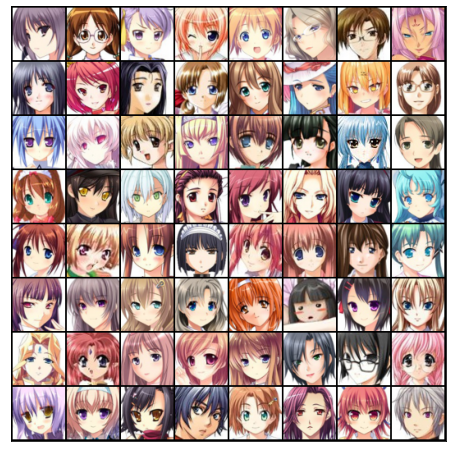

In [26]:
show_batch(train_dl)

In [27]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_dl, device)

In [30]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [31]:
discriminator = to_device(discriminator, device)

In [32]:
latent_size = 128

In [33]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


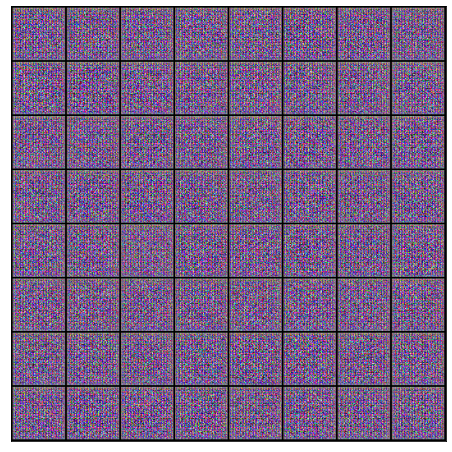

In [34]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [35]:
generator = to_device(generator, device)

In [36]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [37]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [38]:
fixed_latent.shape

torch.Size([64, 128, 1, 1])

In [39]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    return fake_images.cpu().detach()

In [40]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40


In [41]:
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images

    

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 5.2838, loss_d: 0.7118, real_score: 0.7814, fake_score: 0.2240


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 4.9154, loss_d: 0.6656, real_score: 0.7758, fake_score: 0.2195


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 5.0420, loss_d: 0.5636, real_score: 0.8036, fake_score: 0.1935


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 5.3359, loss_d: 0.4771, real_score: 0.8315, fake_score: 0.1660


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 5.5633, loss_d: 0.4297, real_score: 0.8496, fake_score: 0.1485


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 5.3477, loss_d: 0.4194, real_score: 0.8572, fake_score: 0.1409


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 5.4482, loss_d: 0.4025, real_score: 0.8646, fake_score: 0.1346


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 5.0569, loss_d: 0.3994, real_score: 0.8721, fake_score: 0.1274


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 5.0260, loss_d: 0.3455, real_score: 0.8860, fake_score: 0.1137


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.9639, loss_d: 0.3986, real_score: 0.8764, fake_score: 0.1232


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 5.0554, loss_d: 0.3082, real_score: 0.8974, fake_score: 0.1020


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.9420, loss_d: 0.3238, real_score: 0.8932, fake_score: 0.1069


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.9075, loss_d: 0.3838, real_score: 0.8949, fake_score: 0.1050


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.6777, loss_d: 0.3312, real_score: 0.8934, fake_score: 0.1059


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.6670, loss_d: 0.3221, real_score: 0.8981, fake_score: 0.1017


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.5978, loss_d: 0.2443, real_score: 0.9176, fake_score: 0.0821


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.6708, loss_d: 0.3575, real_score: 0.8937, fake_score: 0.1064


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.6916, loss_d: 0.3280, real_score: 0.9010, fake_score: 0.0985


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.5036, loss_d: 0.2920, real_score: 0.9100, fake_score: 0.0896


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.5477, loss_d: 0.3240, real_score: 0.9033, fake_score: 0.0967


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.6362, loss_d: 0.2982, real_score: 0.9125, fake_score: 0.0867


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.5744, loss_d: 0.2935, real_score: 0.9147, fake_score: 0.0860


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 4.6311, loss_d: 0.2588, real_score: 0.9151, fake_score: 0.0844


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.6680, loss_d: 0.3094, real_score: 0.9114, fake_score: 0.0885


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 4.6654, loss_d: 0.2847, real_score: 0.9209, fake_score: 0.0788


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 4.4465, loss_d: 0.2598, real_score: 0.9250, fake_score: 0.0762


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 4.2733, loss_d: 0.3518, real_score: 0.9098, fake_score: 0.0888


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 4.4422, loss_d: 0.2936, real_score: 0.9201, fake_score: 0.0795


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 4.5221, loss_d: 0.2453, real_score: 0.9227, fake_score: 0.0784


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 4.7397, loss_d: 0.3057, real_score: 0.9157, fake_score: 0.0834


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 4.7253, loss_d: 0.1972, real_score: 0.9419, fake_score: 0.0579


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 4.8788, loss_d: 0.2100, real_score: 0.9353, fake_score: 0.0648


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.7850, loss_d: 0.2587, real_score: 0.9279, fake_score: 0.0719


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 4.9409, loss_d: 0.2126, real_score: 0.9400, fake_score: 0.0601


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.8180, loss_d: 0.2488, real_score: 0.9327, fake_score: 0.0670


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 4.9559, loss_d: 0.2097, real_score: 0.9392, fake_score: 0.0605


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 4.6913, loss_d: 0.2388, real_score: 0.9332, fake_score: 0.0668


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 5.2814, loss_d: 0.1823, real_score: 0.9465, fake_score: 0.0537


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 5.3491, loss_d: 0.1785, real_score: 0.9479, fake_score: 0.0516


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 5.1510, loss_d: 0.1558, real_score: 0.9521, fake_score: 0.0482


In [42]:
        if epoch == epochs - 1:
          save_samples(epoch, fixed_latent, show=False)

Saving generated-images.png


In [45]:
generated_img = cv2.imread(f'./generated/generated-images.png')
generated_img = generated_img[:, :, [2, 1, 0]]

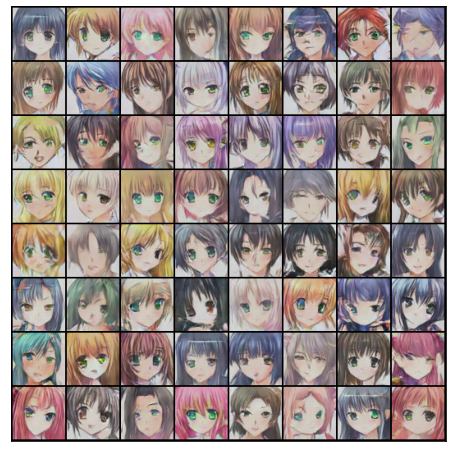

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)